# Exploring Raw Data with _ctapipe_

Here are just some very simplistic examples of going through and inspecting the raw data, using only the very simple pieces that are implemented right now. 

In [1]:
# some setup (need to import the things we will use later)
from ctapipe.utils.datasets import get_path
from ctapipe.io.hessio import hessio_event_source
from ctapipe import visualization, io
from matplotlib import pyplot as plt
from astropy import units as u
%matplotlib inline  

path /home/jacquem/workspace/CTA/pyhessio/pyhessio


to read HESSIO format data, one must first make sure you install the `pyhessioxxx` module separately (currently it is not included as part of ctapipe), and make sure it is in your `PYTHONPATH`.  Then the following line will work:

In [2]:
source = hessio_event_source(get_path("gamma_test.simtel.gz"), max_events=100)

## looking at what is in the event

In [3]:
event = next(source)  # get next event
print(event)
print(event.dl0)

{'_meta': ctapipe.core.Container("meta", hessio__max_events, hessio__input, pixel_pos),
 '_name': 'hessio_container',
 'count': 0,
 'dl0': ctapipe.io.containers.RawData("RawData", tel, run_id, event_id, tels_with_data),
 'mc': ctapipe.io.containers.MCShowerData("MCShowerData", core_x, core_y, alt, az, energy),
 'trig': ctapipe.io.containers.CentralTriggerData("CentralTriggerData", tels_with_trigger, gps_time)}
{'_name': 'RawData',
 'event_id': 408,
 'run_id': 31964,
 'tel': {38: ctapipe.io.containers.RawCameraData("CT038", adc_samples, adc_sums, num_channels),
         47: ctapipe.io.containers.RawCameraData("CT047", adc_samples, adc_sums, num_channels)},
 'tels_with_data': {38, 47}}


the event is just a class with a bunch of data items in it.  You can see a more compact represntation via:

In [4]:
print(repr(event))
print(repr(event.dl0))

ctapipe.core.Container("hessio_container", trig, dl0, count, mc)
ctapipe.io.containers.RawData("RawData", tel, run_id, event_id, tels_with_data)


In [5]:
print(event.dl0.tels_with_data)

{38, 47}


note that the event has 2 telescopes in it: 38,40... Let's try the next one:

In [6]:
event = next(source) # get the next event
print(event.dl0.tels_with_data)

{11, 21, 118, 119, 24, 26, 61, 63}


now, we have a larger event with many telescopes... Let's look at the data from **CT24**:

In [7]:
teldata = event.dl0.tel[24]
print(teldata)
teldata

{'_name': 'CT024',
 'adc_samples': {0: array([[106, 110,  96, ...,  88,  95,  84],
       [ 94,  97, 107, ...,  90,  92, 102],
       [ 97,  90,  94, ...,  90,  87,  85],
       ..., 
       [ 92,  85,  92, ...,  89,  95,  88],
       [104, 101, 103, ..., 117, 126, 127],
       [101,  99, 104, ...,  97,  97,  91]], dtype=uint16)},
 'adc_sums': {0: array([2945, 3013, 2951, ..., 2771, 3152, 3017], dtype=int32)},
 'num_channels': 1}


ctapipe.io.containers.RawCameraData("CT024", adc_samples, adc_sums, num_channels)

again, `event.tel_data` contains a data structure for the telescope data, with some fields like `adc_samples`.

Let's make a 2D plot of the sample data (sample vs pixel), so we can see if we see the event:

/home/jacquem/anaconda3/envs/cta/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


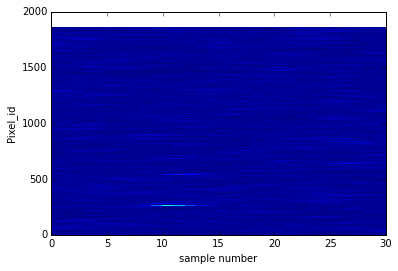

In [8]:
plt.pcolormesh(teldata.adc_samples[0])  # note the [0] is for channel 0
plt.xlabel("sample number")
plt.ylabel("Pixel_id")

Let's zoom in to see if we can identify the pixels that have the Cherenkov signal in them

adc_samples[0] is an array of shape (N_pix,N_slice) = (1855, 30)


/home/jacquem/anaconda3/envs/cta/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


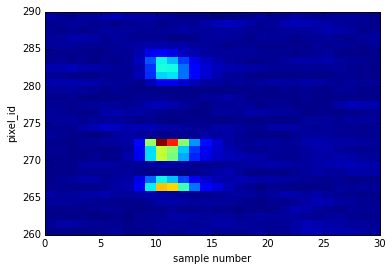

In [9]:
plt.pcolormesh(teldata.adc_samples[0])
plt.ylim(260,290)
plt.xlabel("sample number")
plt.ylabel("pixel_id")
print("adc_samples[0] is an array of shape (N_pix,N_slice) =",teldata.adc_samples[0].shape)

Now we can really see that some pixels have a signal in them!

Lets look at a 1D plot of pixel 270 in channel 0 and see the signal:

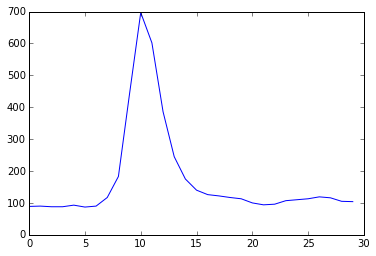

In [10]:
trace = teldata.adc_samples[0][270]   
plt.plot(trace)

Great! It looks like a *standard Cherenkov signal*!

Let's take a look at several traces to see if the peaks area aligned:

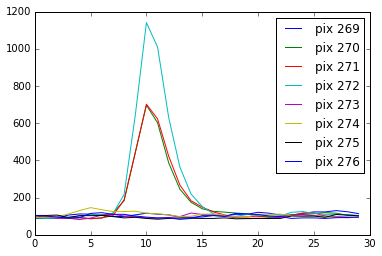

In [11]:
for pix_id in [269,270,271,272,273,274,275,276]:
    plt.plot(teldata.adc_samples[0][pix_id], label="pix {}".format(pix_id))
plt.legend()

Let's define the integration windows first:

By eye, they seem to be reaonsable from sample 8 to 13 for signal, and 20 to 29 for pedestal

/home/jacquem/anaconda3/envs/cta/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


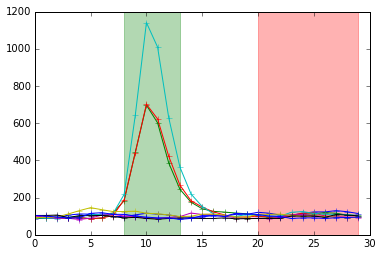

In [12]:
for pix_id in [269,270,271,272,273,274,275,276]:
    plt.plot(teldata.adc_samples[0][pix_id],'+-')
plt.fill_betweenx([0,1200],20,29,color='red',alpha=0.3)
plt.fill_betweenx([0,1200],8,13,color='green',alpha=0.3)

## Very simplisitic trace analysis:
Now, let's for example calculate a signal and background in a the fixed windows we defined for this single event:

In [13]:
data = teldata.adc_samples[0]
peds = data[:, 20:29].mean(axis=1)  # mean of samples 20 to 30 for all pixels
sums = data[:, 8:13].sum(axis=1)/(13-8)    # simple sum integration

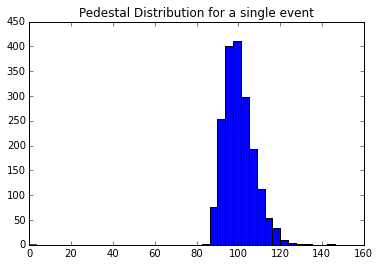

In [14]:
phist = plt.hist(peds, bins=40, range=[0,150])
plt.title("Pedestal Distribution for a single event")

let's now take a look at the pedestal-subtracted sums and a pedestal-subtracted signal:


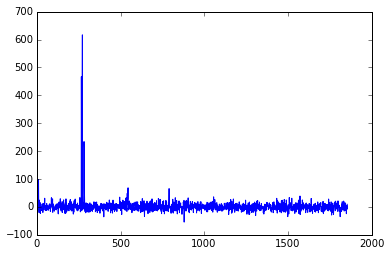

In [15]:
plt.plot(sums - peds)

In [ ]:
# we can also subtract the pedestals from the traces themselves, which would be needed to compare peaks properly
for ii in range(270,280):
    plt.plot(data[ii] - peds[ii])

## camera displays
better yet, let's do it in 2D! At this point, the ArrayConfig data model is not implemented, so there is not a good way to load all the camera definitions (right now it is hacked into the `hessio_event_source`, which will at least read the pixel positions from the file)

In [ ]:
pix_x, pix_y= event.meta.pixel_pos[24] 
camgeom = io.CameraGeometry.guess(pix_x*u.m, pix_y*u.m) # just guess the geometry from the pix pos

In [ ]:
title="CT24, run {} event {} ped-sub".format(event.dl0.run_id,event.dl0.event_id)
disp = visualization.CameraDisplay(camgeom,title=title)
disp.image = sums - peds 
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)  # autoscale

It looks like a nice signal! We have plotted our pedestal-subtracted trace integral, and see the shower clearly!

Let's look at all telescopes:

In [ ]:
for tel in event.dl0.tels_with_data:
    plt.figure()
    pix_x, pix_y= event.meta.pixel_pos[tel] 
    camgeom = io.CameraGeometry.guess(pix_x*u.m, pix_y*u.m) # just guess the geometry from the pix pos
    title="CT{}, run {} event {}".format(tel,event.dl0.run_id,event.dl0.event_id)
    disp = visualization.CameraDisplay(camgeom,title=title)
    disp.image = event.dl0.tel[tel].adc_sums[0]
    disp.cmap = plt.cm.RdBu_r
    disp.add_colorbar()
    disp.set_limits_percent(95)

# some signal processing...

Let's try to detect the peak using the scipy.signal package:
http://docs.scipy.org/doc/scipy/reference/signal.html

In [ ]:
from scipy import signal
import numpy as np

In [ ]:
pix_ids = np.arange(len(data))
has_signal = sums > 300

widths = np.array([8,]) # peak widths to search for (let's fix it at 8 samples, about the width of the peak)
peaks = [signal.find_peaks_cwt(trace,widths) for trace in data[has_signal] ]

for p,s in zip(pix_ids[has_signal],peaks):
    print("pix{} has peaks at sample {}".format(p,s))
    plt.plot(data[p])
    plt.scatter(np.array(s),data[p,s])

clearly the signal needs to be filtered first, or an appropriate wavelet used, but the idea is nice